# Автокодировщики

Объект описывается слишком большим количеством признаков? Хочется уменьшить их чилсло и не потерять важную информацию? Вам надоел PCA? Тогда автокодировщики идут к вам! 

## Почиташки 

* [Хорошая серия статей](https://habrahabr.ru/post/331382/) про автокодировщики и GAN. Немного подворовал код у них. 
* [Глава книги](http://www.deeplearningbook.org/contents/autoencoders.html) deep learning book, на которой основана серия сатей выше. 
* [Статья из блога про Keras](https://blog.keras.io/building-autoencoders-in-keras.html), на которой также основана статья выше (все воруют код у всех, просто ужас, блин). 
* [Неделя 4 курса Introduction to deep learning](https://www.coursera.org/learn/intro-to-deep-learning/home/week/4), с которой также взята часть материалов, и на которой я был ментором. Можно заодно [посмотреть тетрадку с этого курса.](https://github.com/hse-aml/intro-to-dl/blob/master/week4/Autoencoders-task.ipynb) Неожиданно, но она тоже с лицами... 

## Про автокодировщики 

Эпоха больших данных даёт нам слишком много данных. Часто хочется, чтобы их было немного поменьше, но при этом они выражали бы всю информацию о великом процессе порождения данных более ёмко. Не потерять в знании, но сэкономить! Именно из такого благородного помысла рождается метод главных компонент. Его посыл очень прост: давайте посмотрим на наши данные, найдём в них те направления, в которых происходит самое сильное изменение и оставим только их. При этом, в плане информации мы бы не потеряли особо много. Именно так часто поступают в случае, когда размерность данных очень большая. Находят $d$ Направлений, разброс в которых покрывает $90\%$ дисперсии, а остальное забывают. 

Например, если у нас есть выборка из карасей и щук и требуется научится отличать одних от ругих, то мы могли бы оставить только информацию о чешуйках, расположенных вдоль первой, более длинной компоненты. На качество нашего классификатора это бы повлияло слабо, но мы, при этом, избавились бы от лишней размерности, от оценки лишнего коэфициента и могли бы пустить большее число наблюдений на оценку меньшего числа параметров.  

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

Главная фишка метода главных компонент состоит в том, что он делает всю эту редукцию линейно. На самом деле все новые признаки будут представлять из себя линейные комбинации из старых. 

Идею такой редукции лишней информации можно обобщить до нелинейного случая и сделать прыжок к нейросетям, которые называются **автоэнокдерами.**  Автоэнкодеры учатся оставлять минимум информации так, чтобы по этому минимуму было возможно восстановить с очень высокой точностью исходную информацию. 

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности кода. 

![](https://hsto.org/web/cf6/228/613/cf6228613fdc4f8fb819cbd41bb677eb.png) 

Закодированную часть Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но, чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки.

Новый пример! Пусть у нас есть куча рукописных цифр и мы хотели бы научить компьютер понимать где какая цифра нарисована. Каждая цифра это картинка из пикселей размер $28 \times 28$. Всего у нас $28^2$ наблюдаемые переменные. Это слишком много! Явно не каждый пиксель несёт в себе информацию о том какая цифра нарисована на картинке. Большая часть пикселей бесполезна. 

Чтобы отобрать самые важные нелинейные комбинации из пикселей, мы можем сделать следующее: 

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Нейросеть получает на вход цифру, пытается оставить 10 самых важных нейлинейных комбинаций из пикселей, а после по этим самым важным комбинациям, она пытается восстановить цифру назад с как можно большей точностью. Ограничение на то сколько самых важных нелинейных пикселей должно остаться, заставляет нашу сетку стараться отобрать исключительно всё самое важное, что можно найти на картинке. Метод главных компонент будет частным, самым простым случаем, такой нейронной сетки. 

Первая часть автокодировщика $g(x)$ называется **encoder**. Она пытается закодировать картинку. Вторая часть $f(h)$ называет **decoder**. Она пытается раскодировать картинку. Автоэккодер, изменяя $f$ и $g$ пытается выучить тождественную функцию 

$$x = f(g(x)),$$ 

минимизируя какой-то функционал ошибки 

$$L(x, f(g(x))).$$ 

При этом выучить тождественную выборку он не может, так как в сердцевине находится  **бутылочное горлышко** с довольно маленьким числом нейронов. В итоге сетка вынуждена отаравлять в сердцевину только те комбинации фичей, по которым легче всего восстановить входные данные, и таким образом отсеивает ненужную информацию. В горлышке в результате обучения оказываются наши новые нелинейные фичи. 

In [1]:
import tensorflow as tf 
tf.__version__

'2.0.0'

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Данные.

Будем учить свой автокодировщик для человеческиз лиц. На самом деле можно взять абсолютно любой датасет, который вам нравится. Например, [с руками, которые играют в камень ножницы бумагу.](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) В Tensorflow стараются добавлять датасеты из самых модных статей. Найдите датасет своей мечты [в каталоге.](https://www.tensorflow.org/datasets/catalog/overview)

In [4]:
!pip install tensorflow_datasets

You should consider upgrading via the 'pip install --upgrade pip' command.


Мы распакуем датасет из генератора. В принципе можно было это не делать и дальше работать с генераторами. С ними мы уже в прошлый раз работали, когда натравливали сетки на конкретные папки.

In [60]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [61]:
# Если компьютер лагает и у вас куча проблем:
name = 'mnist'

# batch_size=-1 чтобы получить полный датасет
data = tfds.load(name=name, batch_size=-1) 
data = tfds.as_numpy(data)  # распаковываем тензоры в numpy

X_test, y_test = data['test']['image']/255, data['test']['label']
X_train, y_train = data['train']['image']/255, data['train']['label']
X_train.shape, X_test.shape


# ВАЖНО:  plt.imshow(X[0,:,:,0], cmap='gray')
# код везде придется переписать в таком формате :) 

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# %%time
# name = 'lfw'

# # batch_size=-1 чтобы получить полный датасет
# data = tfds.load(name=name, batch_size=-1) 
# data = tfds.as_numpy(data)  # распаковываем тензоры в numpy

# X = data['train']['image']
# y = data['train']['label']

# X = X/255

In [ ]:
# %%time
# # Чтобы код работал быстрее можно ухудшить качество картинок
# X = tf.image.resize(X, [48, 48]).numpy()

# plt.imshow(X[0])
# X.shape

In [ ]:
#%%time
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Если интересно как именно выглядит код, который подгружает данные, можно [заглянуть на git tensorflow.](https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/image)  Глянем на данные.

(28, 28, 1)

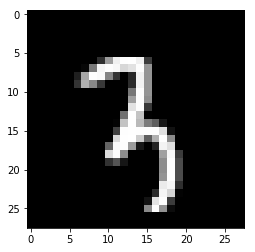

In [9]:
plt.imshow(X_train[0,:,:,0], cmap='gray')
X_train[0].shape

Хочу ещё данных!

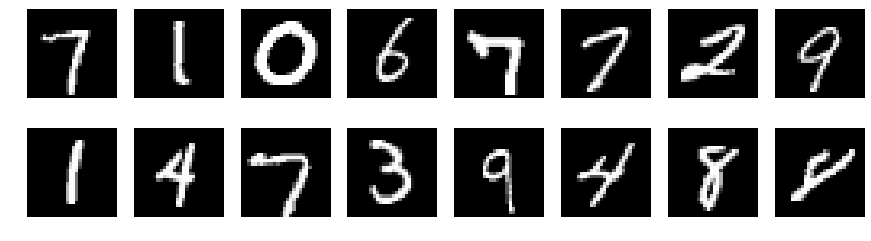

In [12]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_train[random_index,:,:,0], cmap='gray')
plt.show()

С этим можно уже учить модели. 

## 2. Собираем автокодировщик для PCA 

Как мы уже выяснили, простейшим автокодировщиком является PCA. Один слой на входе, бутылочное горлышко с новыми фичами, один слой на выходе и PCA готов. 

In [14]:
input_shape = X_train.shape[1:]
input_shape

(28, 28, 1)

In [16]:
np.prod(input_shape) # пикселей

784

In [17]:
def build_pca_autoencoder(img_shape, code_size=36):
    # code_size это размерность кодированного представления (фичей на выходе)
    
    # Энкодер 
    encoder = Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten())             # Вспомогательный слой решейпинга 
    encoder.add(L.Dense(code_size))      # Обратите внимание, что нет активации 
    
    # Декодер 
    decoder = Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))
    return encoder,decoder

Осталось только собрать модель из моделей. 

In [19]:
# Сконструировали энкодер и декодер 
encoder, decoder = build_pca_autoencoder(input_shape, code_size=36)

inp = L.Input(input_shape)  # Вход
code = encoder(inp)         # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Скрепили две наши сетки в одну общую модель
autoencoder = Model(inp, reconstruction)

# Собираем сеть с методом оптимизации и выбранной ошибкой 
autoencoder.compile('adam', 'mse') 

# Посмотрим на параметры 
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 36)                28260     
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


Обратите внимание что энкодер восстанавливает вход на выходе. У нас нет меток для обучения, а надо, чтобы ими были сами по себе исходные картинки. Немного подправим генератор данных, чтобы это правда было так. 

In [22]:
# Обучаем модель 
hist_1 = autoencoder.fit(x = X_train, y = X_train,  # Обратите внимание что энкодер восстанавливает вход на выходе 
                epochs = 10,                        # Никакие y тут не нужны. Это просто лэйблы... 
                batch_size = 256,
                shuffle = True,
                validation_data = [X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0159 - val_loss: 0.0155
Epoch 2/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0159 - val_loss: 0.0154
Epoch 3/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0159 - val_loss: 0.0154
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 7/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 8/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 9/10
60000/60000 [==============================] - 1s 14us/sample - loss: 0.0158 - val_

Наш автокодировщик обучился. это довольно приятная новость. Попробуем отрисовать оригинальные изображения, их компактные представления и то как по этим представлениям изображения восстанавливаются. 

In [24]:
# Функция для отрисовки ооигинальных цифр, их представления и восстановленного рисунка
def visualize(img, encoder, decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img[:,:,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1)[:,:,0], cmap='gray')
    plt.show()

Final MSE: 0.01537619402706623


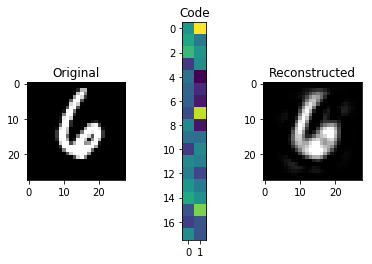

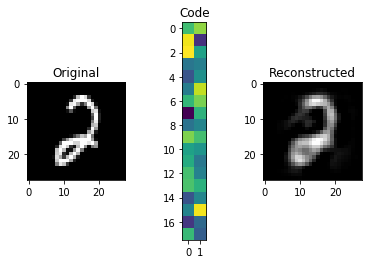

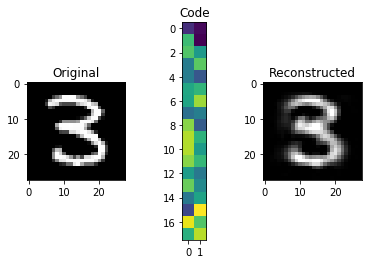

In [26]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

Теперь по оставшимся 36 фичам (вместо оригинальных 784) можно строить классификаторы. Попробуйте на досуге заняться этим весёлым занятием, а мы движемся дальше. 

## 3 Глубокий автоэнкодер 

Всегда можно лучше! Сконструируем глубокий автокодировщик для вычленения нелинейных фичей. 

![ ](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

* Обратите внимание, что при постройке автокодировщика не должно быть слоёв меньших, чем бутылочное горлышко (выход энкодера). 
* Также обратите внимание, что вполне уместно использовать свёртки и пулинг, но такой автокодировщик будет построен чуточку ниже. 

In [31]:
def build_deep_autoencoder(input_shape, code_size=36):
    # code_size это размерность кодированного представления 
    
    # Энкодер 
    encoder = Sequential()
    encoder.add(L.InputLayer(input_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten()) # Вспомогательный слой решейпинга 
   
    # Слои глубокого энкодера 
    encoder.add(L.Dense(code_size*2, activation='relu'))
    encoder.add(L.Dense(code_size, activation='linear')) # Бутылочное горлышко
    
    # Декодер 
    decoder = Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    
    # Слои глубокого декодирования
    decoder.add(L.Dense(code_size*2, activation='relu'))  # Обратите внимание, что слои идут в обратном порядке
    decoder.add(L.Dense(np.prod(input_shape))) # Развёртываем картинку 
    decoder.add(L.Reshape(input_shape))
    return encoder,decoder

# Сконструировали энкодер и декодер 
encoder,decoder = build_deep_autoencoder(input_shape, code_size=36)

inp = L.Input(input_shape)        # Вход
code = encoder(inp)             # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder = Model(inp,reconstruction)
autoencoder.compile('adam',loss='mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 

# Посмотрим на параметры 
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 36)                59148     
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 1)         59896     
Total params: 119,044
Trainable params: 119,044
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Обучаем модель 
hist_2 = autoencoder.fit(x = X_train, y = X_train,  # Обратите внимание что энкодер восстанавливает вход на выходе 
                epochs = 10,                 # Никакие y тут не нужны. Это просто лэйблы... 
                batch_size = 256,
                shuffle = True,
                validation_data=[X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0440 - val_loss: 0.0257
Epoch 2/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0226 - val_loss: 0.0198
Epoch 3/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0192 - val_loss: 0.0180
Epoch 4/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.0179 - val_loss: 0.0171
Epoch 5/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0173 - val_loss: 0.0168
Epoch 6/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0171 - val_loss: 0.0166
Epoch 7/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0168 - val_loss: 0.0163
Epoch 8/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0166 - val_loss: 0.0162
Epoch 9/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0165 - val_

Final MSE: 0.016033292552828787


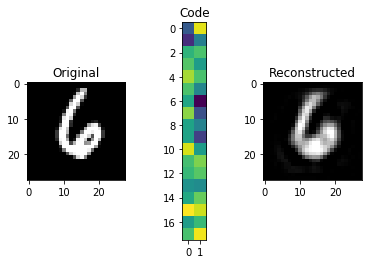

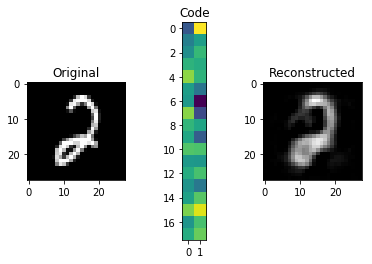

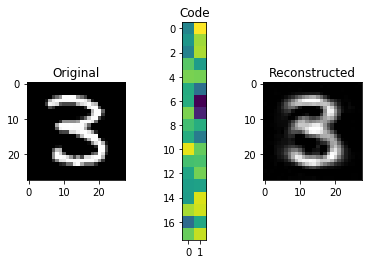

In [33]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

## 4. Свёрточный автокодировщик 

Добавим свёрточные слои и немного макспулинга. Это позволит сделать автокдировщик инвариантным к расположению цифр в пространстве. 

In [35]:
def build_conv_autoencoder(input_shape, code_size=36):
    # code_size это размерность кодированного представления 
    
    # Энкодер 
    encoder = Sequential()
    encoder.add(L.InputLayer(input_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Conv2D(64, kernel_size=(6,6),activation='relu',padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2,2),padding='same'))
    encoder.add(L.Conv2D(16, kernel_size = (2,2),activation='relu',padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2,2),padding='same'))
    encoder.add(L.Conv2D(1, kernel_size = (6,6), activation = 'relu', padding='same'))
    # На этом моменте представление  (6, 6, 1) т.е. 36-размерное
       
    # Декодер 
    decoder = Sequential()
    decoder.add(L.InputLayer((6, 6, 1))) # Принимаем закодированное представление на вход (РАЗМЕРНОСТЬ!)
    decoder.add(L.Conv2D(16, kernel_size= (6,6), activation='relu', padding='same'))
    decoder.add(L.UpSampling2D((2,2)))
    decoder.add(L.Conv2D(64, kernel_size = (2,2), activation='relu', padding='same'))
    decoder.add(L.UpSampling2D((2,2)))
    decoder.add(L.Conv2D(1,kernel_size =(6,6), padding='same', activation='sigmoid'))
    return encoder,decoder


# Сконструировали энкодер и декодер 
encoder,decoder = build_conv_autoencoder(input_shape,code_size=36)

inp = L.Input(input_shape)  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder =  Model(inp,reconstruction)
autoencoder.compile('adamax',loss='mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
# Посмотрим на параметры 
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 7, 7, 1)           7057      
_________________________________________________________________
sequential_11 (Sequential)   multiple                  7057      
Total params: 14,114
Trainable params: 14,114
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Модель будет обучаться ну оооочень долго... 
# Ошибка падает довольно быстро, добавлять свёртку было хорошей идеей
hist_3 = autoencoder.fit(X_train, X_train,
                        epochs=1,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 220s 4ms/sample - loss: 0.1130 - val_loss: 0.1140


In [41]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

Final MSE: 0.11396316770315171


## 5. Denoising автоэнкодер 

Автоэнкодеры можно обучить убирать шум из данных: для этого надо на вход подавать зашумленные данные и на выходе сравнивать с данными без шума. Создадим модель, которая будет зашумлять входное изображение, а после пытаться избавить его от шума. 

In [42]:
# Добавляем на картинку немного шума 
def apply_gaussian_noise(X,sigma=0.01):
    return X + sigma*np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

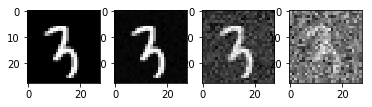

In [43]:
plt.subplot(1,4,1)
plt.imshow(X_train[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.01)[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.1)[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.5)[0].reshape(28,28), cmap = 'gray');

In [44]:
# Зашумляем данные 
X_train_noisy = apply_gaussian_noise(X_train, sigma=0.1)
X_test_noisy = apply_gaussian_noise(X_test, sigma=0.1)

# Убираем все заскоки за отрезок [0;1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Собираем сеточку из предыдущего пункта.

In [47]:
# Размер у горлышка как у входа, соответствует 28**2
encoder,decoder = build_deep_autoencoder(input_shape, code_size=512)

inp = L.Input(input_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile('adam','mse')

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 512)               1328640   
_________________________________________________________________
sequential_15 (Sequential)   (None, 28, 28, 1)         1328912   
Total params: 2,657,552
Trainable params: 2,657,552
Non-trainable params: 0
_________________________________________________________________


In [48]:
hist_noise = autoencoder.fit(X_train_noisy, X_train,
                        epochs=10,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0190 - val_loss: 0.0080
Epoch 2/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0067 - val_loss: 0.0056
Epoch 3/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0051 - val_loss: 0.0047
Epoch 4/10
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0044 - val_loss: 0.0042
Epoch 5/10
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 6/10
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 7/10
60000/60000 [==============================] - 10s 161us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 8/10
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 9/10
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0

Final MSE: 0.0034489150747656822


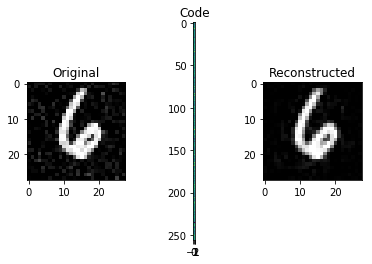

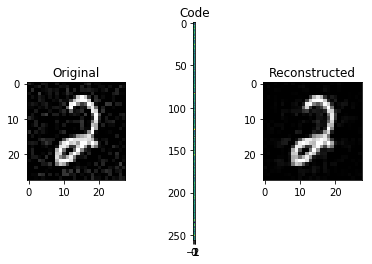

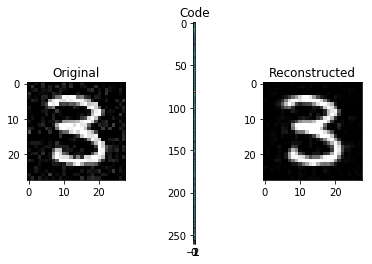

In [49]:
score = autoencoder.evaluate(X_test_noisy, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test_noisy[i]
    visualize(img,encoder,decoder)

## 6.  Поиск похожих изображений 

С помощью найденного горлышка можно искать похожие друг на друга изображения. Чтобы ускорить процесс поиска, мы будем использовать похожий на метод ближайших соседей, но более быстрый алгоритм под названием [Locality Sensitive Hashing forest.](http://scikit-learn.org/0.16/modules/generated/sklearn.neighbors.LSHForest.html)

In [51]:
images = X_train
codes = encoder.predict(images)

# хорошая идея ставить по ходу архитекрутуры проверки на размерности :) 
assert len(codes) == len(images)

In [62]:
import sklearn
sklearn.__version__

'0.20.3'

In [52]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/usr/local/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [54]:
def get_similar(image, n_neighbors=5):
    
    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [55]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.reshape(28,28), cmap = 'gray')
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].reshape(28,28), cmap = 'gray')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

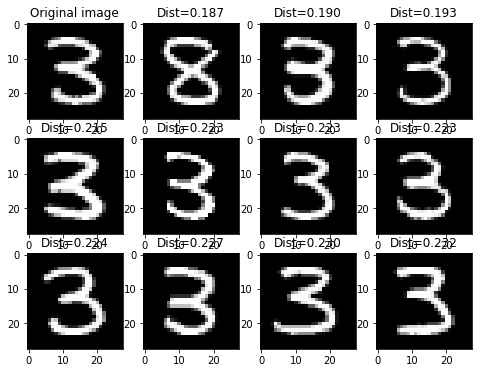

In [56]:
show_similar(X_test[2])

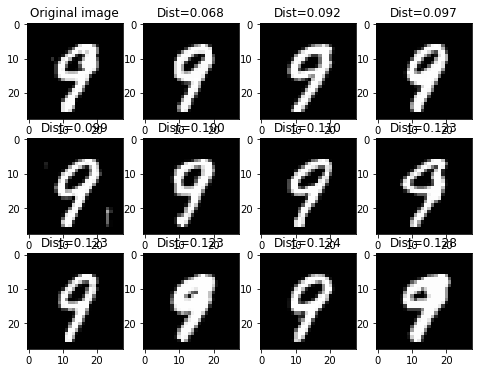

In [57]:
show_similar(X_test[500])

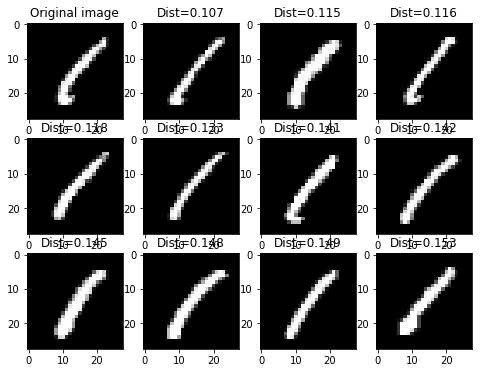

In [59]:
show_similar(X_test[66])